In [1]:
import os
import sys
sys.path.insert(0, "../")

import h5py
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import plotly.express as px
import numpy as np

import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader

import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Notebook for the Points of Interest (PsOI) code
After predicting the condition of the road we will like to get the predictions to point to specfic coordinates on a real map, such that we can see where exactly there is deficiencies on the road.

This notebook will go trough the 3 steps of this process which we will be explained with the figure below

<div style="text-align:center">
    <img src="../reports/figures/jupyter/POI/POI_figure.png" style="width:90%">
</div>



### Step 1 - Map the Measurements of Interest (MsOI) to the PsOI 
First we will look at the upper half of the figure. The grey line in the middle reassembles the entire right side of the road, that is covered in this study. It is divided into points of interest (POIs); one for each meter. The yellow lines above are all the cars passes, i.e. their drive from the start to the end of the road. These passes are divided into segments based on when the car had a speed below 5 Km/h. In total there are 218 segments, with the first 82 of them being on the right side of the road and the last 136 being on the left side. The black lines, |, in each segment represents the the measurements which are calculated for each second. Notice that "Car 1, Pass 1, Segment 3, Second 4" (C1,P1,S3,S4) and C2,P1,S3,S3, have different distances between their one-second measurements. That is due to the cars having different speeds, thus C2,P1,S3,S3 has travelled further in one second than C1,P1,S3,S4. 

The script for this is `src/data/points_of_interest_mapping.py`

### Step 2 - Give the MsOI weights 
Now we are interested in looking at a specific POI, indicated by the green dotted lines, and figure out what the condition of the road is there. The long vertical black line is there to showcase what seconds of the segments are of interest in each pass. Looking at C1,P1 we can see that it is the fourth second of the third segment which is the closest measurement to this. The implementation is made such that the POI will look for the two closest seconds in each pass, but a threshold is put in place such that the measurements has to be closer than $10^{-4}$ (11.1 meters) to be used. As there is 250 measurements each second only the closest location is used - one could the average instead. Each POI then have a number of measurements of interest (MsOI), on average 73, which can be used to calculate the condition of the POI. 

Then the weights for each MOI are calculated based on their distances **d** to the POI. A small example is shown below
\begin{align}
    \mathbf{d} &= [2.54, 5.93, 8.63]\times 10^{-5} \\
    \mathbf{w} &= -\log\left(\frac{\mathbf{d}}{\sum \mathbf{d}}\right) \\
    \mathbf{w}_{norm} &= \frac{\mathbf{w}}{\sum \mathbf{w}} \\
    \mathbf{w}_{norm} &= [0.52, 0.29, 0.19]
\end{align}



The script for this is `src/data/points_of_interest_weights.py`

### Step 3 - Plot the predictions on a real map
Now it is time to plot the predicitons on a real map. It is also here that the  MsOI are  multiplied with their corresponding weights to obtain the prediction of POI the actual road.

The script for this is `src/data/points_of_interest_to_road.py`

# Step 1 - Map the Measurements of Interest (MsOI) to the PsOI

In [2]:
from src.data.points_of_interest_mapping import *

First we will get all the relevant data

In [3]:
# Get the segments 
segments = h5py.File('../data/processed/w_kpis/segments.hdf5', 'r')
all_trip_names, pass_lists = define_trips_and_passes(segments)

# Right side data
autopi_hh = unpack_hdf5('../data/raw/AutoPi_CAN/platoon_CPH1_HH.hdf5')
gm_data_hh = autopi_hh['GM']['16006']['pass_1'] # uneven passes are HH routes
p79_hh = pd.read_csv('../data/raw/ref_data/cph1_zp_hh.csv', sep=';', encoding='unicode_escape')

# Left side data
autopi_vh = unpack_hdf5(f'../data/raw/AutoPi_CAN/platoon_CPH1_VH.hdf5')
gm_data_vh = autopi_vh['GM']['16006']['pass_2'] # even passes are VH routes
p79_vh = pd.read_csv('../data/raw/ref_data/cph1_zp_vh.csv', sep=';', encoding='unicode_escape')  

<HDF5 file "platoon_CPH1_HH.hdf5" (mode r)>
<HDF5 file "platoon_CPH1_VH.hdf5" (mode r)>


We will now check if the file already exists, otherwise we will run the code, which takes approxitmly 1 hour and 15 minuttes to run

In [4]:
file_path = "../data/AOI/mapping_hh_time_to_location.hdf5"

# Go trough both sides (takes 1 hour 15 min to run on Macbook 2019 16GB RAM 2.6 GHz 6-Core Intel Core i7)
if not os.path.exists(file_path):
    print("File does not exist")
    gm_data = [gm_data_hh, gm_data_vh] 
    p79 = [p79_hh, p79_vh]
    directions = ['hh', 'vh']
    for gm_data_, p79_, direction in zip(gm_data, p79, directions):
            locations = get_locations(p79_, gm_data_)
            mapping = map_time_to_area_of_interst(segments, locations, all_trip_names, pass_lists, direction)
            cleaned_mapping = filter_entries(mapping)
            save_to_csv(cleaned_mapping, direction)
            save_to_hdf5(cleaned_mapping, direction)
else:
    print("File exists")

File exists


# Step 2 - Give the MsOI weights

In [5]:
from src.data.points_of_interest_weights import *

Either we run the code or else we load the mapping

In [6]:
file_path = "../data/AOI/AOI_weighted_mapping_hh.hdf5"

if not os.path.exists(file_path):
    # Takes about 40 seconds to load
    mapping_with_weights_hh = load_from_hdf5("../data/AOI/mapping_hh_time_to_location.hdf5")
    mapping_with_weights_vh = load_from_hdf5("../data/AOI/mapping_vh_time_to_location.hdf5")
    print("Loaded mapping")

    # Get weights for each index
    weights_hh = calculate_weights(mapping_with_weights_hh)
    weights_vh = calculate_weights(mapping_with_weights_vh)

    # Save the weights to a file
    save_to_hdf5(weights_hh, "hh")
    save_to_hdf5(weights_vh, "vh")

else:
    # Takes about 45 seconds to load
    weights_hh = read_from_hdf5("../data/AOI/AOI_weighted_mapping_hh.hdf5")
    weights_vh = read_from_hdf5("../data/AOI/AOI_weighted_mapping_vh.hdf5")
    print("Loaded weights")

Loaded weights


# Step 3 - Plot the predictions on a real map

In [7]:
from src.data.feature_dataloader import Features
from src.models.hydramr import HydraMRRegressor
from src.data.points_of_interest_to_road import predict, model_loader, get_all_predictions, get_predictions_for_POIs, get_kpis_for_POIs

locations_hh = get_locations(p79_hh, gm_data_hh)
locations_vh = get_locations(p79_vh, gm_data_vh)
print("Loaded locations")

Loaded locations


### KPI DATA

In [8]:
# Takes 2 min and 30 sec seconds to run
gm = h5py.File('../data/processed/w_kpis/segments.hdf5', 'r')

# Get right side kpis
lat_hh, lon_hh, kpis_POI_di_hh, kpis_POI_rut_hh, kpis_POI_pi_hh, kpis_POI_iri_hh, \
    kpis_POI_di_std_hh, kpis_POI_rut_std_hh, kpis_POI_pi_std_hh, kpis_POI_iri_std_hh \
    = get_kpis_for_POIs(weights_hh, locations_hh, gm)

# Get left side kpis
lat_vh, lon_vh, kpis_POI_di_vh, kpis_POI_rut_vh, kpis_POI_pi_vh, kpis_POI_iri_vh, \
    kpis_POI_di_std_vh, kpis_POI_rut_std_vh, kpis_POI_pi_std_vh, kpis_POI_iri_std_vh \
    = get_kpis_for_POIs(weights_vh, locations_vh, gm)

# Combine the data
lat = lat_hh + lat_vh
lon = lon_hh + lon_vh
kpis_POI_di = kpis_POI_di_hh + kpis_POI_di_vh
kpis_POI_rut = kpis_POI_rut_hh + kpis_POI_rut_vh
kpis_POI_pi = kpis_POI_pi_hh + kpis_POI_pi_vh
kpis_POI_iri = kpis_POI_iri_hh + kpis_POI_iri_vh
kpis_POI_di_std = kpis_POI_di_std_hh + kpis_POI_di_std_vh
kpis_POI_rut_std = kpis_POI_rut_std_hh + kpis_POI_rut_std_vh
kpis_POI_pi_std = kpis_POI_pi_std_hh + kpis_POI_pi_std_vh
kpis_POI_iri_std = kpis_POI_iri_std_hh + kpis_POI_iri_std_vh


### Our Data

In [11]:
import yaml
from torch.utils.data import DataLoader


def NB_model_loader(experiment_dir, model_name):
    prefix = experiment_dir.split("data/")[0]
    model_path = os.path.join(experiment_dir, model_name)
    params_path = os.path.join(experiment_dir, "model_params.yml")

    with open(params_path, 'r') as stream:
        model_params = yaml.safe_load(stream)

    # Get fold if not specified
    fold = model_params["trained_in_fold"][model_name]
    feature_path = os.path.join(prefix, model_params["data"])
    batch_size = model_params["batch_size"]

    feature_extractors = model_params["feature_extractors"]
    hidden_dim = model_params["hidden_dim"]
    batch_norm = model_params["batch_norm"]
    model_depth = model_params["model_depth"]

    datasets = {
        "train": Features(feature_path, data_type="train", feature_extractors=feature_extractors, fold=fold),
        "val": Features(feature_path, data_type="val", feature_extractors=feature_extractors, fold=fold),
        "test": Features(feature_path, data_type="test", feature_extractors=feature_extractors, fold=fold)
    }

    dataloaders = {
        "train": DataLoader(datasets["train"], batch_size=batch_size, shuffle=False, num_workers=0),
        "val": DataLoader(datasets["val"], batch_size=batch_size, shuffle=False, num_workers=0),
        "test": DataLoader(datasets["test"], batch_size=batch_size, shuffle=False, num_workers=0)
    }

    # Load the model
    input_shape, target_shape = datasets["train"].get_data_shape()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = HydraMRRegressor(in_features=input_shape[0], out_features=target_shape[0], hidden_dim=hidden_dim, model_depth=model_depth, batch_norm=batch_norm)
    model.load_state_dict(torch.load(model_path, map_location=device))

    
    return datasets, dataloaders, model

In [9]:
# Define and load model 
experiment_dir = "../models/HydraMRRegressor"
model_name = "HydraMRRegressor.pt"

datasets, dataloaders, model = model_loader(experiment_dir, model_name)

# Get predictions 
road_predictions = get_all_predictions(datasets, dataloaders, model)

# prepare the predictions
lat_hh, lon_hh, preds_POI_di_hh, preds_POI_rut_hh, preds_POI_pi_hh, preds_POI_iri_hh, \
    preds_POI_di_std_hh, preds_POI_rut_std_hh, preds_POI_pi_std_hh, preds_POI_iri_std_hh \
    = get_predictions_for_POIs(weights_hh, locations_hh, road_predictions)

lat_vh, lon_vh, preds_POI_di_vh, preds_POI_rut_vh, preds_POI_pi_vh, preds_POI_iri_vh, \
    preds_POI_di_std_vh, preds_POI_rut_std_vh, preds_POI_pi_std_vh, preds_POI_iri_std_vh \
    = get_predictions_for_POIs(weights_vh, locations_vh, road_predictions)

# Combine the data
lat = lat_hh + lat_vh
lon = lon_hh + lon_vh
preds_POI_di = preds_POI_di_hh + preds_POI_di_vh
preds_POI_rut = preds_POI_rut_hh + preds_POI_rut_vh
preds_POI_pi = preds_POI_pi_hh + preds_POI_pi_vh
preds_POI_iri = preds_POI_iri_hh + preds_POI_iri_vh
preds_POI_di_std = preds_POI_di_std_hh + preds_POI_di_std_vh
preds_POI_rut_std = preds_POI_rut_std_hh + preds_POI_rut_std_vh
preds_POI_pi_std = preds_POI_pi_std_hh + preds_POI_pi_std_vh
preds_POI_iri_std = preds_POI_iri_std_hh + preds_POI_iri_std_vh

Arguments: 
                     Data Path:             ../data/processed/features.hdf5 
                     Data Type:             train 
                     Data length:           6550 
                     Features selected:                      
                         - Names:           ['HydraMV_8_64'] 
                         - KPI Window Size: 1 
                     
Arguments: 
                     Data Path:             ../data/processed/features.hdf5 
                     Data Type:             val 
                     Data length:           1638 
                     Features selected:                      
                         - Names:           ['HydraMV_8_64'] 
                         - KPI Window Size: 1 
                     
Arguments: 
                     Data Path:             ../data/processed/features.hdf5 
                     Data Type:             test 
                     Data length:           1446 
                     Features selected:        

train RMSE: 0.41


val RMSE: 0.67


test RMSE: 0.70


### Single plot

In [10]:
# Choose on of the value to plot, as seen below
metric = "iri_kpis"

df = pd.DataFrame({
    "lat": lat,
    "lon": lon,
    "di_kpis": kpis_POI_di,
    "rut_kpis": kpis_POI_rut,
    "pi_kpis": kpis_POI_pi,
    "iri_kpis": kpis_POI_iri,
    "di_std_kpis": kpis_POI_di_std,
    "rut_std_kpis": kpis_POI_rut_std,
    "pi_std_kpis": kpis_POI_pi_std,
    "iri_std_kpis": kpis_POI_iri_std,
    "di_pred": preds_POI_di,
    "rut_pred": preds_POI_rut,
    "pi_pred": preds_POI_pi,
    "iri_pred": preds_POI_iri,
    "di_std_pred": preds_POI_di_std,
    "rut_std_pred": preds_POI_rut_std,
    "pi_std_pred": preds_POI_pi_std,
    "iri_std_pred": preds_POI_iri_std
})

fig = px.scatter_mapbox(df, lat="lat", lon="lon", hover_name=None, 
    hover_data=["lat", "lon", "di_kpis", "di_pred", "rut_kpis", "rut_pred", "pi_kpis", "pi_pred", "iri_kpis", "iri_pred"], 
    color=metric, color_continuous_scale=px.colors.sequential.Magma_r, width=600, height=500)
fig.update_layout(mapbox_style="open-street-map", mapbox_zoom=14.3, mapbox_center={"lat": 55.707024, "lon": 12.523765})
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Double plot

In [26]:
# Choose one of the values to plot, as seen below
metric = "iri"

values_to_plot = ["di", "rut", "pi", "iri", "di_std", "rut_std", "pi_std", "iri_std"]

# Get max and min of the metric looking at both df[f"{metric}_kpis"] and df[f"{metric}_pred"]
max_val = max(df[f"{metric}_kpis"].max(), df[f"{metric}_pred"].max())
min_val = min(df[f"{metric}_kpis"].min(), df[f"{metric}_pred"].min())

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("KPIs", "Predictions"), specs=[[{"type": "scattermapbox"}, {"type": "scattermapbox"}]])

# Create traces for the KPIs
trace_kpis = go.Scattermapbox(
    lat=df["lat"], lon=df["lon"],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=5,
        color=df[f"{metric}_kpis"],
        colorscale='jet',
        cmin=min_val,
        cmax=max_val,
        showscale=True,
        colorbar=dict(title=f"{metric} KPIs", x=0.45)
    ),
    text=df[[f"{metric}_kpis"]],
    hoverinfo='text',
    showlegend=False
)

# Create traces for the Predictions
trace_preds = go.Scattermapbox(
    lat=df["lat"], lon=df["lon"],
    mode='markers',
    marker=go.scattermapbox.Marker(
        size=5,
        color=df[f"{metric}_pred"],
        colorscale='jet',
        cmin=min_val,
        cmax=max_val,
        showscale=True,
        colorbar=dict(title=f"{metric} Predictions", x=1.0)
    ),
    text=df[[f"{metric}_pred"]],
    hoverinfo='text',
    showlegend=False
)

# Add traces to the figure
fig.add_trace(trace_kpis, row=1, col=1)
fig.add_trace(trace_preds, row=1, col=2)

# Update layout
fig.update_layout(
    mapbox1=dict(
        style="open-street-map",
        zoom=13.9,
        center=dict(lat=55.707024, lon=12.523765)
    ),
    mapbox2=dict(
        style="open-street-map",
        zoom=13.9,
        center=dict(lat=55.707024, lon=12.523765)
    ),
    margin=dict(r=0, t=0, l=0, b=0)
)

# Show plot
fig.show()

### Predictions plotted with +/- 1 standard deivation

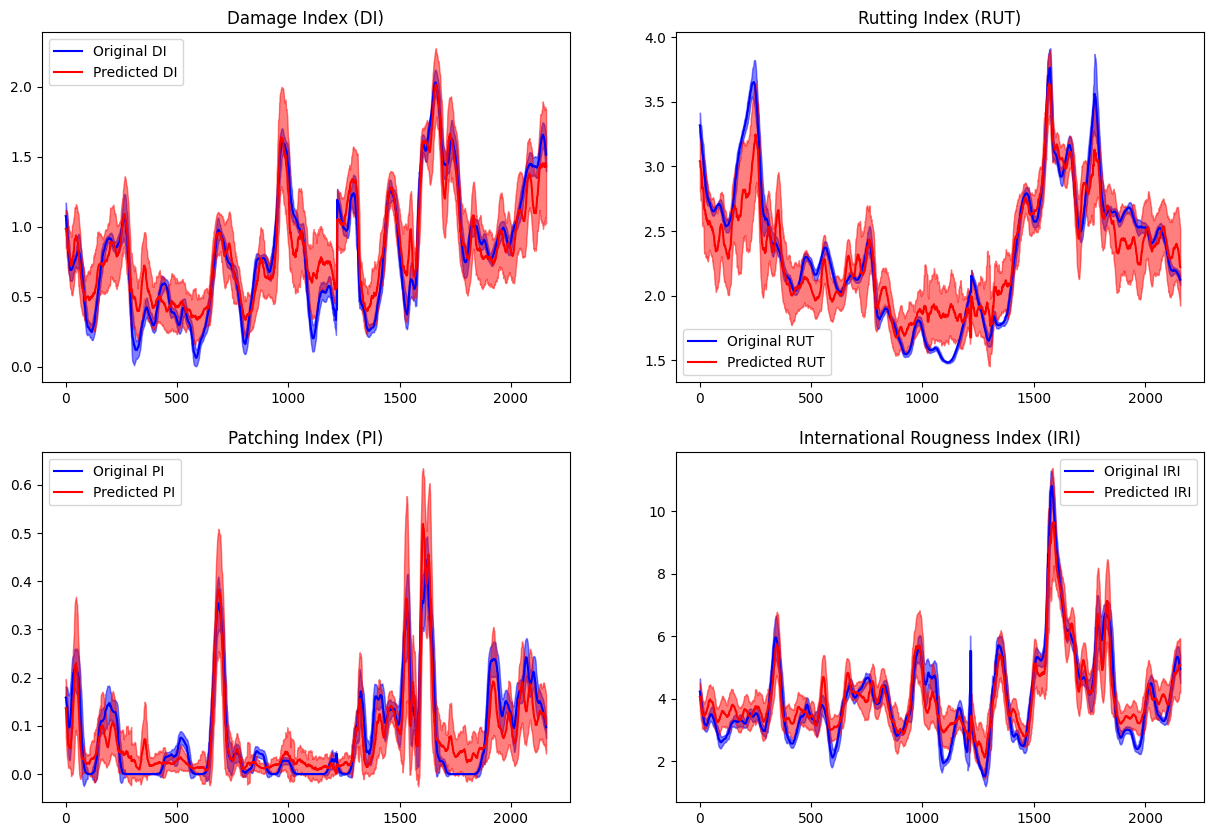

In [27]:
# TODO insert a dashed line between right side and left side

# Plot combined KPIs
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# DI subplot
ax[0, 0].plot(kpis_POI_di, label="Original DI", color='blue')
ax[0, 0].fill_between(range(len(kpis_POI_di)), 
                      [di - std for di, std in zip(kpis_POI_di, kpis_POI_di_std)], 
                      [di + std for di, std in zip(kpis_POI_di, kpis_POI_di_std)], 
                      alpha=0.5, color='blue')
ax[0, 0].plot(preds_POI_di, label="Predicted DI", color='red')
ax[0, 0].fill_between(range(len(preds_POI_di)), 
                      [di - std for di, std in zip(preds_POI_di, preds_POI_di_std)], 
                      [di + std for di, std in zip(preds_POI_di, preds_POI_di_std)], 
                      alpha=0.5, color='red')
ax[0, 0].set_title("Damage Index (DI)")
ax[0, 0].legend()

# RUT subplot
ax[0, 1].plot(kpis_POI_rut, label="Original RUT", color='blue')
ax[0, 1].fill_between(range(len(kpis_POI_rut)), 
                      [rut - std for rut, std in zip(kpis_POI_rut, kpis_POI_rut_std)], 
                      [rut + std for rut, std in zip(kpis_POI_rut, kpis_POI_rut_std)], 
                      alpha=0.5, color='blue')
ax[0, 1].plot(preds_POI_rut, label="Predicted RUT", color='red')
ax[0, 1].fill_between(range(len(preds_POI_rut)), 
                      [rut - std for rut, std in zip(preds_POI_rut, preds_POI_rut_std)], 
                      [rut + std for rut, std in zip(preds_POI_rut, preds_POI_rut_std)], 
                      alpha=0.5, color='red')
ax[0, 1].set_title("Rutting Index (RUT)")
ax[0, 1].legend()

# PI subplot
ax[1, 0].plot(kpis_POI_pi, label="Original PI", color='blue')
ax[1, 0].fill_between(range(len(kpis_POI_pi)), 
                      [pi - std for pi, std in zip(kpis_POI_pi, kpis_POI_pi_std)], 
                      [pi + std for pi, std in zip(kpis_POI_pi, kpis_POI_pi_std)], 
                      alpha=0.5, color='blue')
ax[1, 0].plot(preds_POI_pi, label="Predicted PI", color='red')
ax[1, 0].fill_between(range(len(preds_POI_pi)), 
                      [pi - std for pi, std in zip(preds_POI_pi, preds_POI_pi_std)], 
                      [pi + std for pi, std in zip(preds_POI_pi, preds_POI_pi_std)], 
                      alpha=0.5, color='red')
ax[1, 0].set_title("Patching Index (PI)")
ax[1, 0].legend(loc='upper left')

# IRI subplot
ax[1, 1].plot(kpis_POI_iri, label="Original IRI", color='blue')
ax[1, 1].fill_between(range(len(kpis_POI_iri)), 
                      [iri - std for iri, std in zip(kpis_POI_iri, kpis_POI_iri_std)], 
                      [iri + std for iri, std in zip(kpis_POI_iri, kpis_POI_iri_std)], 
                      alpha=0.5, color='blue')
ax[1, 1].plot(preds_POI_iri, label="Predicted IRI", color='red')
ax[1, 1].fill_between(range(len(preds_POI_iri)), 
                      [iri - std for iri, std in zip(preds_POI_iri, preds_POI_iri_std)], 
                      [iri + std for iri, std in zip(preds_POI_iri, preds_POI_iri_std)], 
                      alpha=0.5, color='red')
ax[1, 1].set_title("International Rougness Index (IRI)")
ax[1, 1].legend()

plt.show()

[[12.53019946, 55.7111808],
 [12.53018721, 55.71117492],
 [12.53017498, 55.71116905],
 [12.53016273, 55.71116317],
 [12.53015047, 55.7111573],
 [12.53013823, 55.71115144],
 [12.53012595, 55.71114557],
 [12.5301137, 55.71113972],
 [12.53010143, 55.71113385],
 [12.53008916, 55.71112798],
 [12.53007692, 55.71112212],
 [12.53006465, 55.71111625],
 [12.53005233, 55.71111035],
 [12.53004023, 55.71110435],
 [12.53002811, 55.71109834],
 [12.53001598, 55.71109233],
 [12.53000388, 55.71108634],
 [12.52999175, 55.71108033],
 [12.52997964, 55.71107434],
 [12.5299675, 55.71106834],
 [12.52995536, 55.71106235],
 [12.52994325, 55.71105636],
 [12.52993111, 55.71105036],
 [12.52991898, 55.71104435],
 [12.52990687, 55.71103836],
 [12.52989469, 55.71103232],
 [12.52988268, 55.71102623],
 [12.52987065, 55.71102012],
 [12.52985862, 55.71101401],
 [12.52984663, 55.71100791],
 [12.52983462, 55.71100179],
 [12.52982263, 55.71099567],
 [12.52981067, 55.71098955],
 [12.52979869, 55.71098341],
 [12.52978673, 55.